In this work autoencoder neural network architecture is applied for image compression. 

TODO

__Идеи__

* Рассмотреть задачу как классификацию битов (точнее, уровней сигнала) (чтобы были квантованные значения низкой битности)

* Добавить в скрытое представление информацию о цифре

In [1]:
# imports

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from lossy_autoencoder import LossyAutoencoder
from image_dataset import ImageDataset
from trainer import train
from utils import (
    plot_dataset, plot_augmentation, plot_learning_curve, plot_data_latent_decoded
)
from pca_visualization import pca_visualization

from torchinfo import summary
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

In [2]:
np.random.seed(42)
torch.manual_seed(42);

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cuda


In [4]:
MNIST_train = datasets.MNIST(
    './mnist', train=True, download=True, 
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
)
MNIST_test = datasets.MNIST(
    './mnist', train=False, download=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
)
print(f"Train set size: {len(MNIST_train.targets)}\nTest set size: {len(MNIST_test.targets)}")

# fit the data into [0; 1] range
X_train = MNIST_train.data / MNIST_train.data.max()
X_test = MNIST_test.data / MNIST_train.data.max()

Train set size: 60000
Test set size: 10000


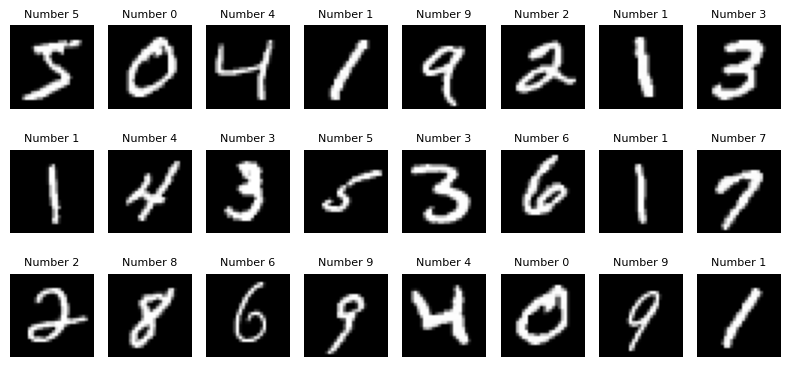

In [5]:
plot_dataset(MNIST_train)

## Lossy autoencoder model

In [6]:
lossy_autoencoder = LossyAutoencoder()
print(summary(lossy_autoencoder))

Layer (type:depth-idx)                   Param #
LossyAutoencoder                         --
├─LossyEncoder: 1-1                      --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  640
│    │    └─PReLU: 3-2                   64
│    │    └─AvgPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  73,856
│    │    └─PReLU: 3-5                   128
│    │    └─AvgPool2d: 3-6               --
│    │    └─Conv2d: 3-7                  73,792
│    │    └─PReLU: 3-8                   64
│    │    └─AvgPool2d: 3-9               --
│    │    └─Conv2d: 3-10                 2,080
│    │    └─PReLU: 3-11                  32
├─LossyDecoder: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─ConvTranspose2d: 3-12        9,248
│    │    └─PReLU: 3-13                  32
│    │    └─ConvTranspose2d: 3-14        25,632
│    │    └─PReLU: 3-15                  32
│    │    └─ConvTranspose2d: 3-16        25,104
│  

In [7]:
print(f'latent space size: {lossy_autoencoder.encode(X_train[0].reshape(1, 1, 28, 28)).shape[1]}')

latent space size: 32


In [8]:
lr = 1e-3         # learning rate 
gamma = 0.98      # exponential lr decay multiplier
batch_size = 100  # batch size of images
num_epochs = 300  # total number of epochs

In [9]:
# Training data augmentation:
# 1) random rotation in range [-15; 15] deg
# 2) random translation along x and y axis in range [-0.1; 0.1] * 28 pixels
# 3) random image scaling with ratio in range [0.9; 1.1]
# 4) random shear parallel to x axis, range [-10, 10] deg
# For these transforms bilinear interpolation is used

train_transforms = v2.Compose([
    v2.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1), 
        scale=(0.9, 1.1), 
        shear=10, 
        interpolation=v2.InterpolationMode.BILINEAR
    )
])

# augmentation before learning, dataset is increased aug_num times

aug_num = 2

old_num = X_train.shape[0]
X_augmented = torch.zeros((old_num * aug_num, 1, *X_train.shape[1:]))
X_augmented[:old_num, 0] = X_train
for i in range(1, aug_num):
    X_augmented[old_num*i:old_num*(i+1), 0] = train_transforms(X_train)

train_dataset = ImageDataset(X_augmented, transform=train_transforms)
test_dataser = ImageDataset(X_test.unsqueeze(1))

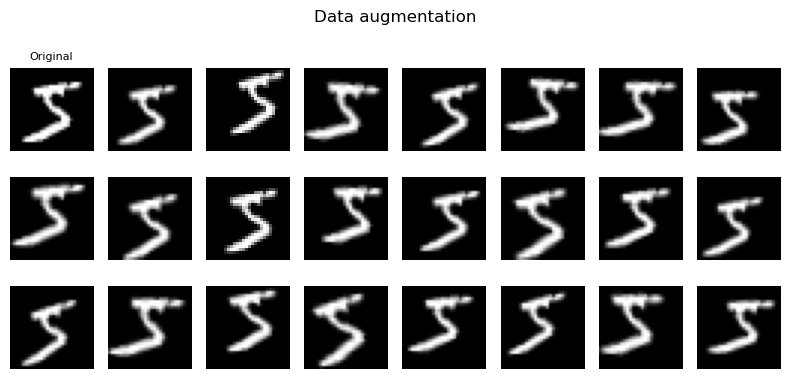

In [10]:
plot_augmentation(X_train[0], train_transforms)

In [11]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataser,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
optimizer = torch.optim.Adam(params=lossy_autoencoder.parameters(), lr=lr, weight_decay=1e-9)
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

In [13]:
loss_logs = train(
    model=lossy_autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device
)

100%|██████████| 300/300 [6:34:50<00:00, 78.97s/it, train=0.0054, test=0.00654]   


In [14]:
# torch.save(lossy_autoencoder.state_dict(), 'lossy_conv_32_real_aug.pth')
#torch.save(lossy_autoencoder.state_dict(), 'lossy_conv_32_real_aug_pre.pth')

# lossy_autoencoder = LossyAutoencoder().to(device)
# lossy_autoencoder.load_state_dict(torch.load('lossy_conv_32_real_aug.pth'))

In [15]:
#np.save('logs_lossy_conv_32_real_aug_pre.npy', loss_logs)
#loss_logs = np.load('logs_lossy_conv_32_real_aug.npy', allow_pickle=True)[()]

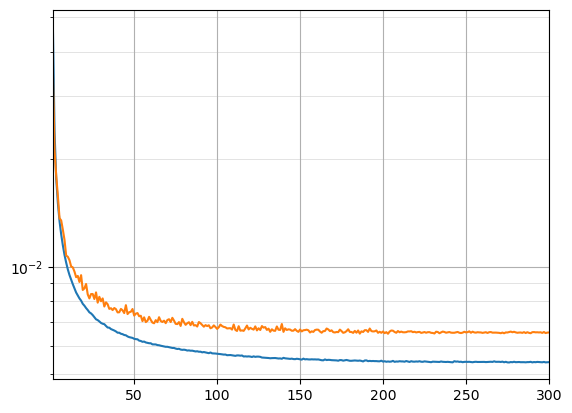

In [26]:
plot_learning_curve(loss_logs, num_epochs, semilogy=True)

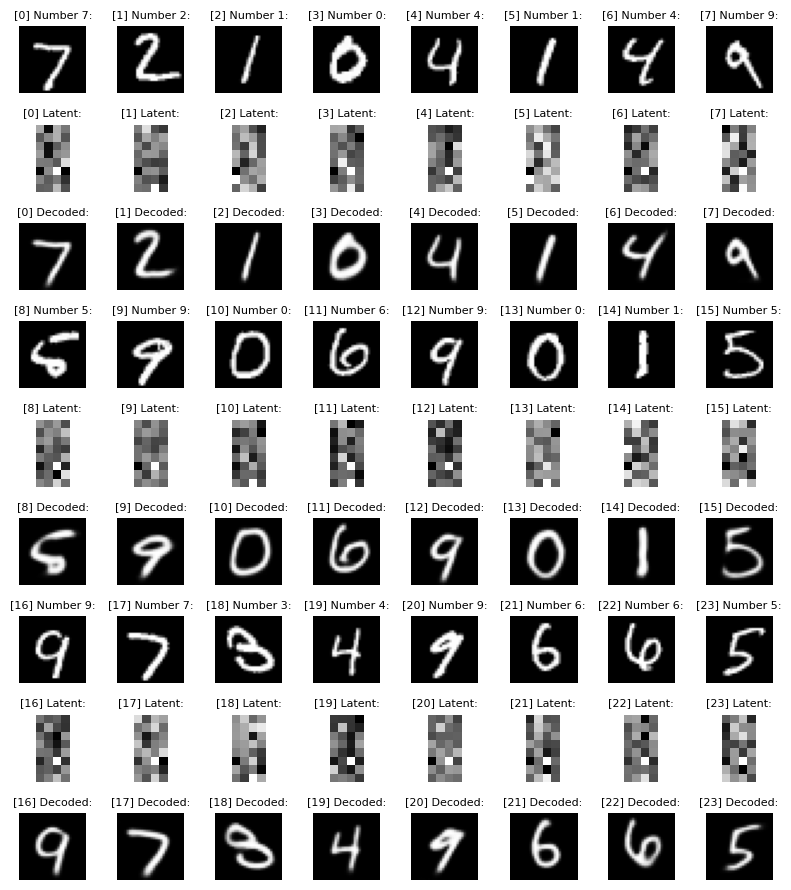

In [25]:
plot_data_latent_decoded(lossy_autoencoder, X_test, MNIST_test.targets, device, lossless=False)

In [18]:
# prepare data for PCA visualization: 
# get latent representaion of train and test datasets
X_train_latent = np.concatenate(
    [lossy_autoencoder.encode(X_train[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(60)]
)
X_test_latent = np.concatenate(
    [lossy_autoencoder.encode(X_test[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(10)]
)

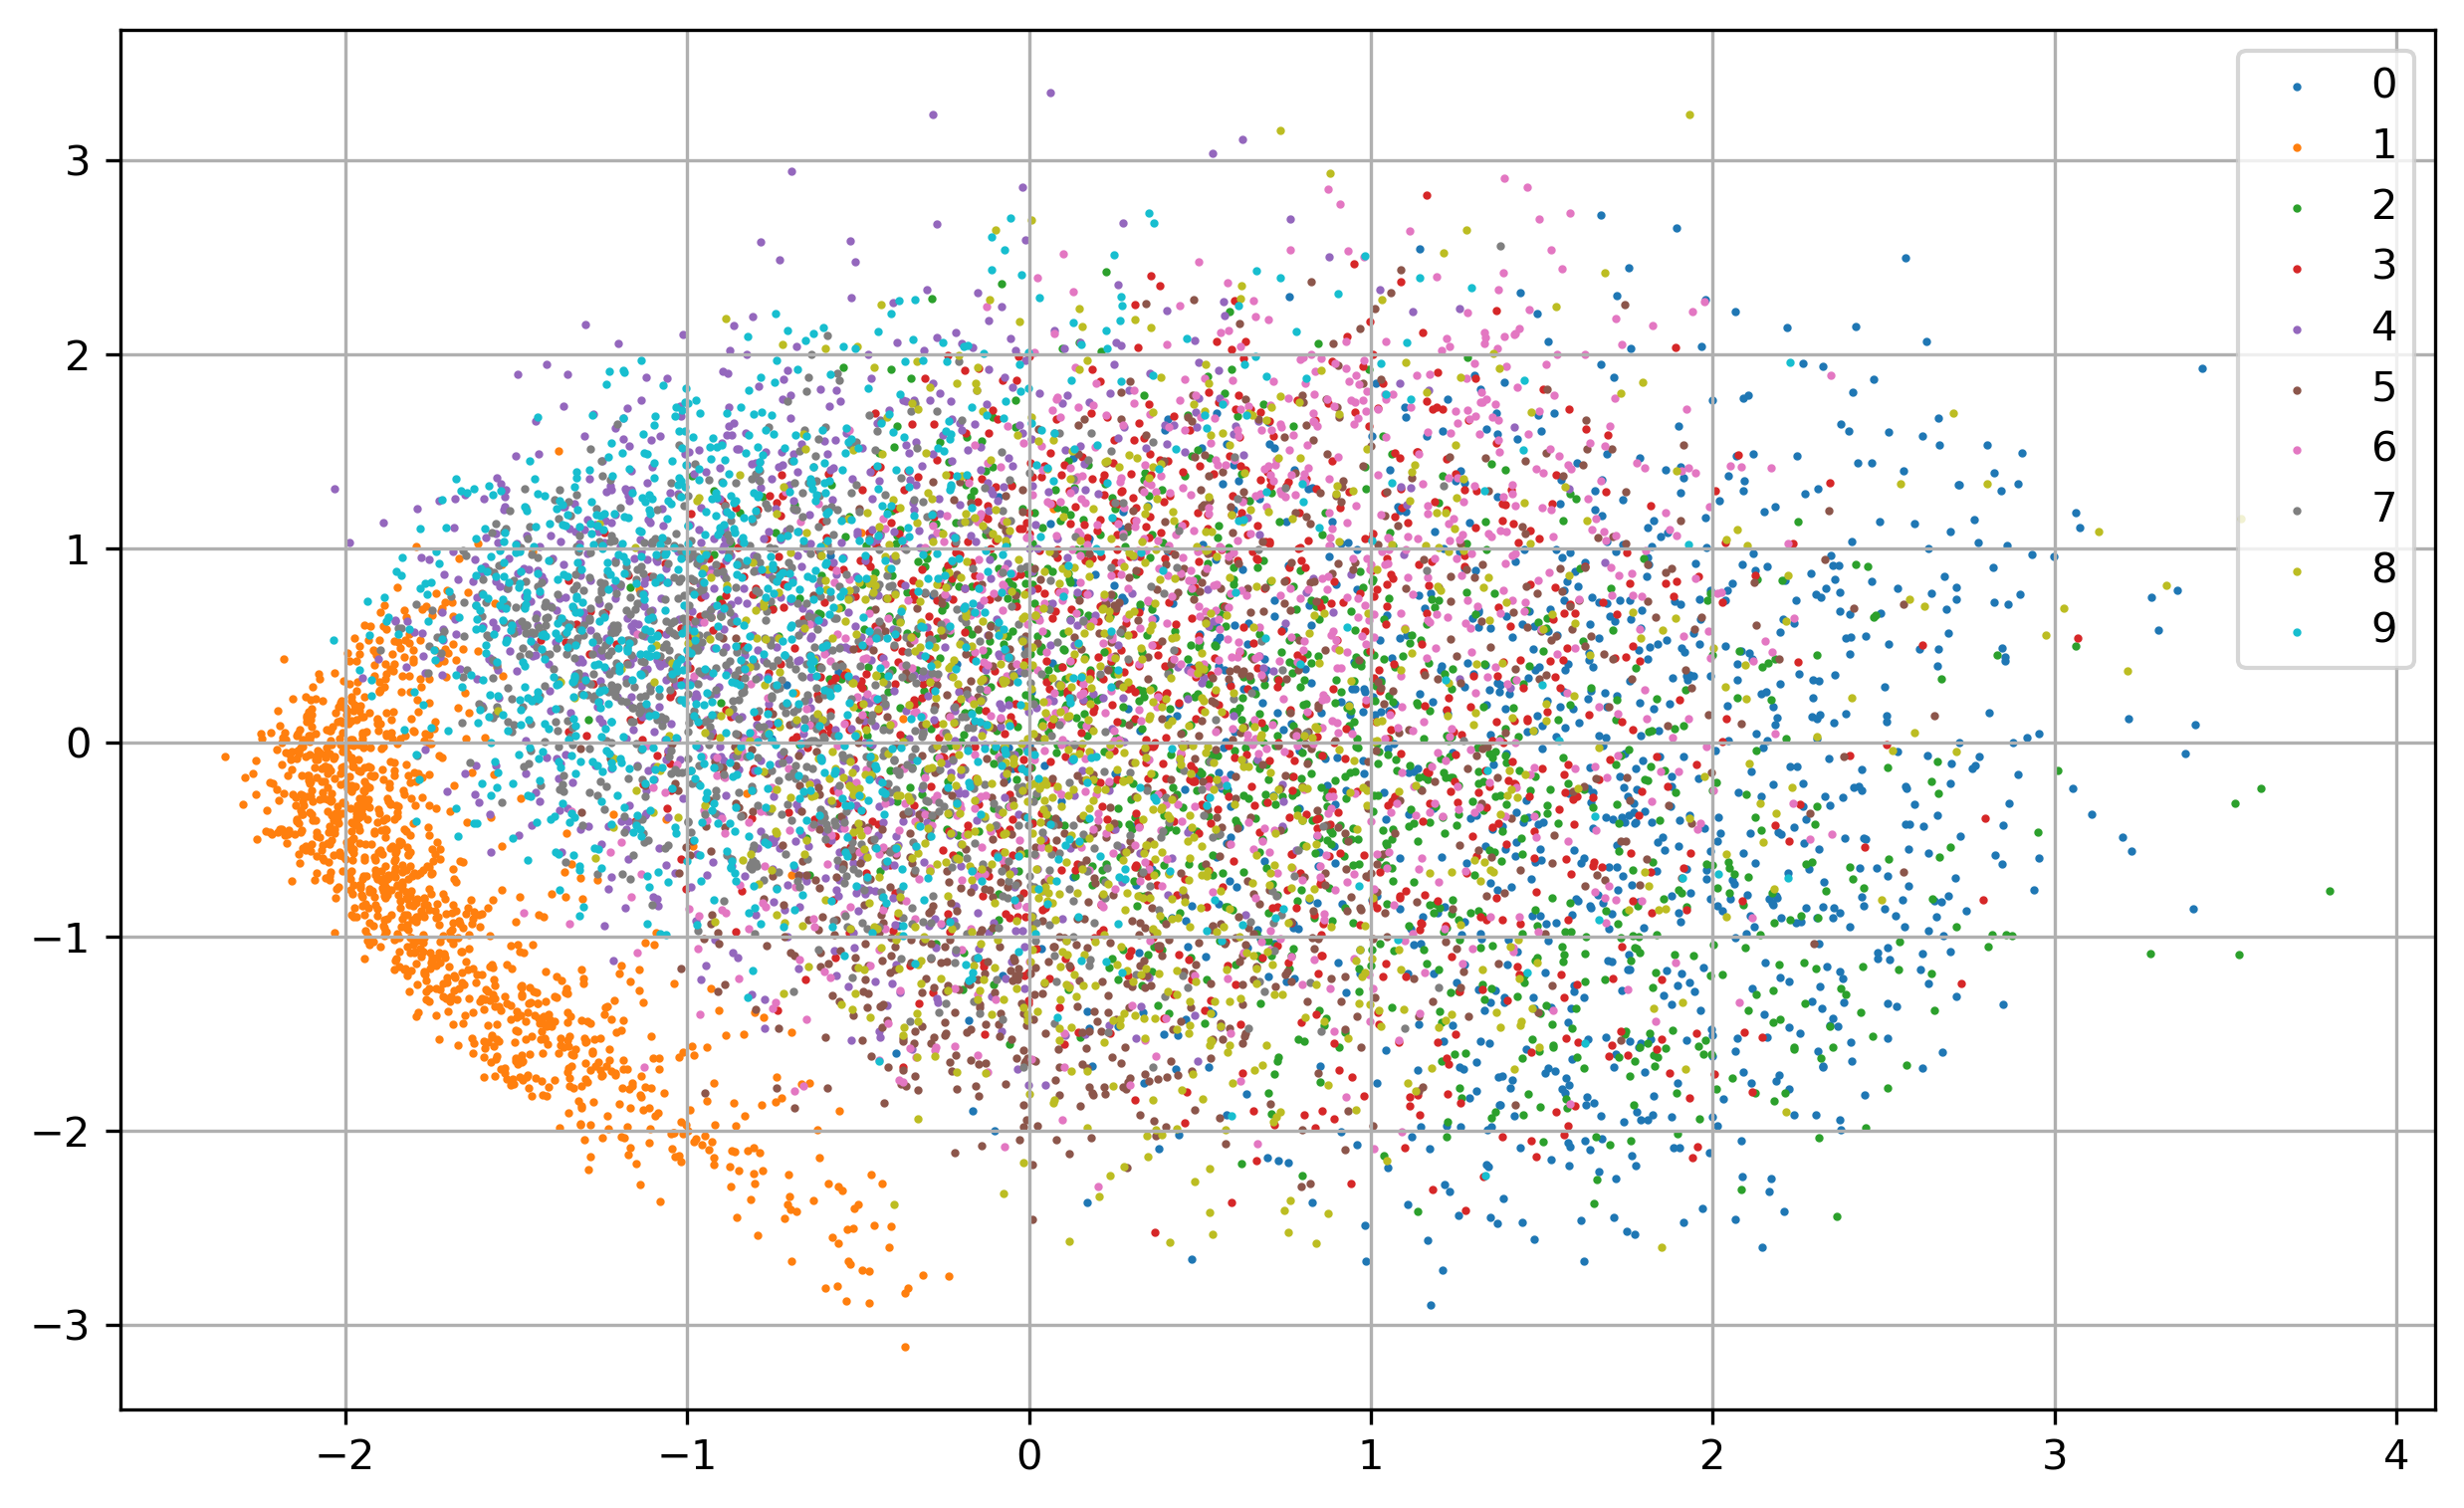

In [19]:
pca_visualization(X_train_latent, X_test_latent, MNIST_test.test_labels)